In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
try:
    import keras.backend as K
    if len(K.tensorflow_backend._get_available_gpus()) > 0:
        from keras.layers import CuDNNLSTM as LSTM
        from keras.layers import CuDNNGRU as GRU
except:
    from keras.layers import LSTM, GRU

from keras.models import Model

from sklearn.metrics import roc_auc_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
word2vec = {}
with open(os.path.join('glove', 'glove.6B', 'glove.6B.100d.txt'), encoding="utf-8") as f :
    for line in f :
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype=np.float32)
        word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors.')

Found 400000 word vectors.


In [4]:
train_df = pd.read_csv(os.path.join('data', 'toxic_comments', 'train.csv'))
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
sentences = train_df['comment_text'].values

In [7]:
possible_labels = train_df.columns[2:].values

In [8]:
targets = train_df[possible_labels].values

In [9]:
print(f'Max sequence length {max(len(s) for s in sentences)}')
print(f'Min sequence length {min(len(s) for s in sentences)}')
s = sorted(len(s) for s in sentences)
print(f'Median sequence length {s[len(s) // 2]}')

Max sequence length 5000
Min sequence length 6
Median sequence length 205


In [10]:
tokenizer = Tokenizer(oov_token='<OOV>', num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [11]:
word2idx = tokenizer.word_index
print(f'Found {len(word2idx)} unique tokens.')

Found 210338 unique tokens.


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(f'Shape of data tensor : {data.shape}')

Shape of data tensor : (159571, 100)


In [13]:
#preparing embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) #keras word indexes start from 1, therefore last index will be 20000 instead of 19999
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items() :
    if i < MAX_VOCAB_SIZE :
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None :
            #words not found will be all zeros
            embedding_matrix[i] = embedding_vector

In [14]:
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [15]:
i = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(i)
x = LSTM(128, return_sequences=True) (x)
x = GlobalMaxPooling1D() (x)
x = Dense(128, activation='relu') (x)
output = Dense(len(possible_labels), activation='sigmoid') (x)

model = Model(i, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                             

In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [17]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Epoch 1/10
998/998 [==============================] - 137s 128ms/step - loss: 0.0698 - accuracy: 0.9816 - val_loss: 0.0542 - val_accuracy: 0.9939
Epoch 2/10
998/998 [==============================] - 130s 131ms/step - loss: 0.0510 - accuracy: 0.9864 - val_loss: 0.0540 - val_accuracy: 0.9928
Epoch 3/10
998/998 [==============================] - 92s 92ms/step - loss: 0.0466 - accuracy: 0.9856 - val_loss: 0.0475 - val_accuracy: 0.9897
Epoch 4/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0439 - accuracy: 0.9894 - val_loss: 0.0513 - val_accuracy: 0.9928
Epoch 5/10
998/998 [==============================] - 54s 55ms/step - loss: 0.0417 - accuracy: 0.9912 - val_loss: 0.0467 - val_accuracy: 0.9863
Epoch 6/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0396 - accuracy: 0.9907 - val_loss: 0.0494 - val_accuracy: 0.9930
Epoch 7/10
998/998 [==============================] - 55s 55ms/step - loss: 0.0378 - accuracy: 0.9902 - val_loss: 0.0511 - val_accur

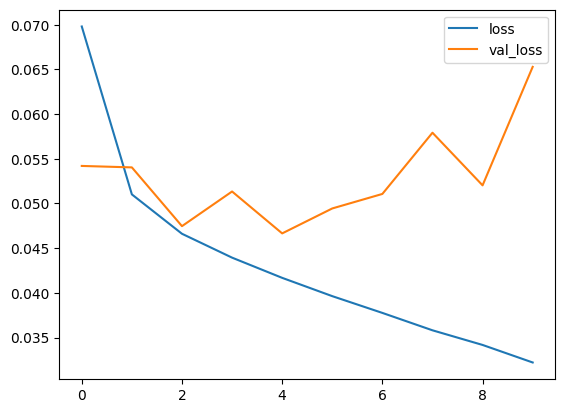

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

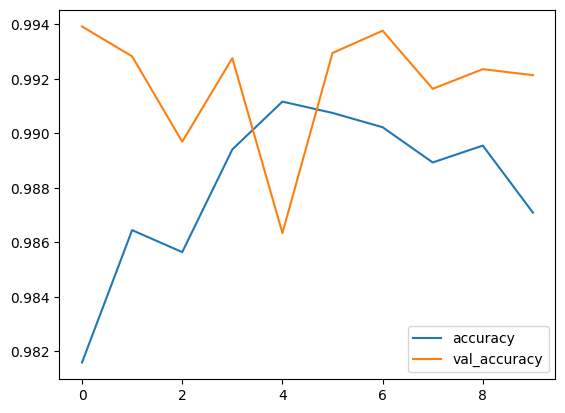

In [19]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [20]:
p = model.predict(data)
aucs= []
for j in range(6) :
    auc = roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 [==============================] - 39s 8ms/step
0.9919127144160057
